# 模型融合
模型融合通常作为比赛的最后一个环节，对结果进行最后提升；

1.  简单加权融合:
    - 回归（分类概率）：算术平均融合（Arithmetic mean），几何平均融合（Geometric mean）；
    - 分类：投票（Voting)
    - 综合：排序融合(Rank averaging)，log融合


2.  stacking/blending:
    - 构建多层模型，并利用预测结果再拟合预测。


3.  boosting/bagging（在xgboost，Adaboost,GBDT中已经用到）:
    - 多树的提升方法


## Stacking & Blending

### 简介

简单来说 stacking 就是当用初始训练数据学习出若干个基学习器后，将这几个学习器的预测结果作为新的训练集，来学习一个新的学习器。

![](http://jupter-oss.oss-cn-hangzhou.aliyuncs.com/public/files/image/2326541042/1584448793231_6TygjXwjNb.jpg)

将个体学习器结合在一起的时候使用的方法叫做结合策略。对于分类问题，我们可以使用投票法来选择输出最多的类。对于回归问题，我们可以将分类器输出的结果求平均值。上面说的投票法和平均法都是很有效的结合策略，还有一种结合策略是使用另外一个机器学习算法来将个体机器学习器的结果结合在一起，这个方法就是Stacking。在stacking方法中，我们把个体学习器叫做初级学习器，用于结合的学习器叫做次级学习器或元学习器（meta-learner），次级学习器用于训练的数据叫做次级训练集。次级训练集是在训练集上用初级学习器得到的。

算法示意图如下：

![](http://jupter-oss.oss-cn-hangzhou.aliyuncs.com/public/files/image/2326541042/1584448806789_1ElRtHaacw.jpg)

* 过程1-3 是训练出来个体学习器，也就是初级学习器。
* 过程5-9是 使用训练出来的个体学习器来得预测的结果，这个预测的结果当做次级学习器的训练集。
* 过程11 是用初级学习器预测的结果训练出次级学习器，得到我们最后训练的模型。

### 方法

首先，我们先从一种“不那么正确”但是容易懂的Stacking方法讲起。

Stacking模型本质上是一种分层的结构，这里简单起见，只分析二级Stacking.假设我们有2个基模型 Model1_1、Model1_2 和 一个次级模型Model2

**Step 1.** 基模型 Model1_1，对训练集train训练，然后用于预测 train 和 test 的标签列，分别是P1，T1

Model1_1 模型训练:

$$
\left(\begin{array}{c}{\vdots} \\ {X_{train}} \\ {\vdots}\end{array}\right) \overbrace{\Longrightarrow}^{\text {Model1_1 Train} }\left(\begin{array}{c}{\vdots} \\ {Y}_{True} \\ {\vdots}\end{array}\right)
$$

训练后的模型 Model1_1 分别在 train 和 test 上预测，得到预测标签分别是P1，T1

$$
\left(\begin{array}{c}{\vdots} \\ {X_{train}} \\ {\vdots}\end{array}\right) \overbrace{\Longrightarrow}^{\text {Model1_1 Predict} }\left(\begin{array}{c}{\vdots} \\ {P}_{1} \\ {\vdots}\end{array}\right)
$$

$$
\left(\begin{array}{c}{\vdots} \\ {X_{test}} \\ {\vdots}\end{array}\right) \overbrace{\Longrightarrow}^{\text {Model1_1 Predict} }\left(\begin{array}{c}{\vdots} \\ {T_{1}} \\ {\vdots}\end{array}\right)
$$

**Step 2.** 基模型 Model1_2 ，对训练集train训练，然后用于预测train和test的标签列，分别是P2，T2

Model1_2 模型训练:

$$
\left(\begin{array}{c}{\vdots} \\ {X_{train}} \\ {\vdots}\end{array}\right) \overbrace{\Longrightarrow}^{\text {Model1_2 Train} }\left(\begin{array}{c}{\vdots} \\ {Y}_{True} \\ {\vdots}\end{array}\right)
$$

训练后的模型 Model1_2 分别在 train 和 test 上预测，得到预测标签分别是P2，T2

$$
\left(\begin{array}{c}{\vdots} \\ {X_{train}} \\ {\vdots}\end{array}\right) \overbrace{\Longrightarrow}^{\text {Model1_2 Predict} }\left(\begin{array}{c}{\vdots} \\ {P}_{2} \\ {\vdots}\end{array}\right)
$$

$$
\left(\begin{array}{c}{\vdots} \\ {X_{test}} \\ {\vdots}\end{array}\right) \overbrace{\Longrightarrow}^{\text {Model1_2 Predict} }\left(\begin{array}{c}{\vdots} \\ {T_{2}} \\ {\vdots}\end{array}\right)
$$

**Step 3.** 分别把P1,P2以及T1,T2合并，得到一个新的训练集和测试集train2,test2.

$$
\overbrace{\left(\begin{array}{c}{\vdots} \\ {P_{1}} \\ {\vdots}\end{array} \begin{array}{c}{\vdots} \\ {P_{2}} \\ {\vdots}\end{array} \right)}^{\text {Train_2 }}  
and 
\overbrace{\left(\begin{array}{c}{\vdots} \\ {T_{1}} \\ {\vdots}\end{array} \begin{array}{c}{\vdots} \\ {T_{2}} \\ {\vdots}\end{array} \right)}^{\text {Test_2 }}
$$

再用 次级模型 Model2 以真实训练集标签为标签训练,以train2为特征进行训练，预测test2,得到最终的测试集预测的标签列 $Y_{Pre}$。

$$
\overbrace{\left(\begin{array}{c}{\vdots} \\ {P_{1}} \\ {\vdots}\end{array} \begin{array}{c}{\vdots} \\ {P_{2}} \\ {\vdots}\end{array} \right)}^{\text {Train_2 }} \overbrace{\Longrightarrow}^{\text {Model2 Train} }\left(\begin{array}{c}{\vdots} \\ {Y}_{True} \\ {\vdots}\end{array}\right)
$$

$$
\overbrace{\left(\begin{array}{c}{\vdots} \\ {T_{1}} \\ {\vdots}\end{array} \begin{array}{c}{\vdots} \\ {T_{2}} \\ {\vdots}\end{array} \right)}^{\text {Test_2 }} \overbrace{\Longrightarrow}^{\text {Model1_2 Predict} }\left(\begin{array}{c}{\vdots} \\ {Y}_{Pre} \\ {\vdots}\end{array}\right)
$$

### 总结

Stacking流程即：

1. 将数据划分为训练集和测试集(test_set)，对训练集进行划分为K个大小相似的集合，取其中一份作为验证集val_set,其余的为训练集train_set；
2. 创建第一层的多个模型，这些模型可以使同质的也可以是异质的；
3. 对于每一个模型来说，train_set和val_set是不一样的，如2.2图所示；然后利用各自的train_set训练各自的模型，训练好的模型对各自的val_set和test_set进行预测，得到val_predict和test_predict；
4. 创建第二层的模型，将每个模型对应的val_predict拼接起来作为第二层的训练集，将所有模型的test_predict取平均值作为第二层的测试集；用训练好的第二层模型对第二层的测试集进行预测，得到的结果即为整个测试集的结果

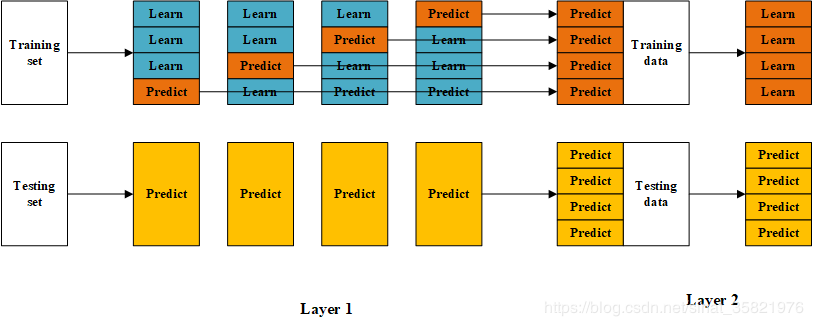

Blending相较于Stacking来说要简单一些，其流程大致分为以下几步：

1. 将数据划分为训练集和测试集(test_set)，其中训练集需要再次划分为训练集(train_set)和验证集(val_set)；
2. 创建第一层的多个模型，这些模型可以使同质的也可以是异质的；
3. 使用train_set训练步骤2中的多个模型，然后用训练好的模型预测val_set和test_set得到val_predict, test_predict1；
4. 创建第二层的模型,使用val_predict作为训练集训练第二层的模型；
5. 使用第二层训练好的模型对第二层测试集test_predict1进行预测，该结果为整个测试集的结果

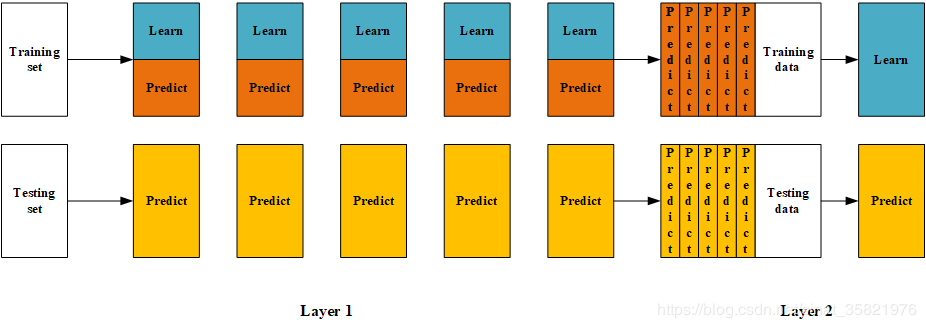

### 对比

Blending的优点在于：

1.比stacking简单（因为不用进行k次的交叉验证来获得stacker feature）

2.避开了一个信息泄露问题：generlizers和stacker使用了不一样的数据集

3.在团队建模过程中，不需要给队友分享自己的随机种子

而缺点在于：

1.使用了很少的数据（是划分hold-out作为测试集，并非cv）

2.blender可能会过拟合（其实大概率是第一点导致的）

3.stacking使用多次的CV会比较稳健

对于实践中的结果而言，stacking和blending的效果是差不多的，所以使用哪种方法都没什么所谓，完全取决于个人爱好。

参考文献：https://zhuanlan.zhihu.com/p/42229791

## 经验总结

比赛的融合这个问题，个人的看法来说其实涉及多个层面，也是提分和提升模型鲁棒性的一种重要方法：

* 1）**结果层面的融合**，这种是最常见的融合方法，其可行的融合方法也有很多，比如根据结果的得分进行加权融合，还可以做Log，exp处理等。在做结果融合的时候，有一个很重要的条件是模型结果的得分要比较近似，然后结果的差异要比较大，这样的结果融合往往有比较好的效果提升。

* 2）**特征层面的融合**，这个层面其实感觉不叫融合，准确说可以叫分割，很多时候如果我们用同种模型训练，可以把特征进行切分给不同的模型，然后在后面进行模型或者结果融合有时也能产生比较好的效果。

* 3）**模型层面的融合**，模型层面的融合可能就涉及模型的堆叠和设计，比如加Staking层，部分模型的结果作为特征输入等，这些就需要多实验和思考了，基于模型层面的融合最好不同模型类型要有一定的差异，用同种模型不同的参数的收益一般是比较小的。

--- By: ML67 

        Email: maolinw67@163.com
        PS: 华中科技大学研究生, 长期混迹Tianchi等，希望和大家多多交流。
        github: https://github.com/mlw67 （近期会做一些书籍推导和代码的整理）

## 代码实现

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
%matplotlib inline

import itertools
import matplotlib.gridspec as gridspec
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
# from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
# from mlxtend.plotting import plot_learning_curves
# from mlxtend.plotting import plot_decision_regions

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

## 数据读取
Train_data = pd.read_csv('data/used_car_train_20200313.csv', sep=' ')
TestA_data = pd.read_csv('data/used_car_testA_20200313.csv', sep=' ')

print(Train_data.shape)
print(TestA_data.shape)

numerical_cols = Train_data.select_dtypes(exclude = 'object').columns
feature_cols = [col for col in numerical_cols if col not in ['SaleID','name','regDate','price']]
print("feature: ", feature_cols)

X_data = Train_data[feature_cols]
Y_data = Train_data['price']

X_test  = TestA_data[feature_cols]

print('X train shape:',X_data.shape)
print('X test shape:',X_test.shape)

# fill na
X_data = X_data.fillna(-1)
X_test = X_test.fillna(-1)

def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))
    print('_std',np.std(data))
    print('_var',np.var(data))

(150000, 31)
(50000, 30)
feature:  ['model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'power', 'kilometer', 'regionCode', 'seller', 'offerType', 'creatDate', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14']
X train shape: (150000, 26)
X test shape: (50000, 26)


In [2]:
# models

def build_model_lr(x_train,y_train):
    reg_model = linear_model.LinearRegression()
    reg_model.fit(x_train,y_train)
    return reg_model

def build_model_ridge(x_train,y_train):
    reg_model = linear_model.Ridge(alpha=0.8)#alphas=range(1,100,5)
    reg_model.fit(x_train,y_train)
    return reg_model

def build_model_lasso(x_train,y_train):
    reg_model = linear_model.LassoCV()
    reg_model.fit(x_train,y_train)
    return reg_model

def build_model_gbdt(x_train,y_train):
    estimator =GradientBoostingRegressor(loss='ls',subsample= 0.85,max_depth= 5,n_estimators = 100)
    param_grid = { 
            'learning_rate': [0.05,0.08,0.1,0.2],
            }
    gbdt = GridSearchCV(estimator, param_grid,cv=3)
    gbdt.fit(x_train,y_train)
    print(gbdt.best_params_)
    # print(gbdt.best_estimator_ )
    return gbdt

def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=120, learning_rate=0.08, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=5) #, objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model

def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=63,n_estimators = 100)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm


### xgb 五折

In [3]:
## xgb
xgr = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) # ,objective ='reg:squarederror'

scores_train = []
scores = []

## 5折交叉验证方式
sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
for train_ind,val_ind in sk.split(X_data,Y_data):
    
    train_x=X_data.iloc[train_ind].values
    train_y=Y_data.iloc[train_ind]
    val_x=X_data.iloc[val_ind].values
    val_y=Y_data.iloc[val_ind]
    
    xgr.fit(train_x,train_y)
    pred_train_xgb=xgr.predict(train_x)
    pred_xgb=xgr.predict(val_x)
    
    score_train = mean_absolute_error(train_y,pred_train_xgb)
    scores_train.append(score_train)
    score = mean_absolute_error(val_y,pred_xgb)
    scores.append(score)

print('Train mae:',np.mean(score_train))
print('Val mae',np.mean(scores))

Train mae: 594.8909340395033
Val mae 693.382067947197


In [4]:
## Split data with val
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.3)

## Train and Predict
print('Predict LR...')
model_lr = build_model_lr(x_train,y_train)
val_lr = model_lr.predict(x_val)
subA_lr = model_lr.predict(X_test)

print('Predict Ridge...')
model_ridge = build_model_ridge(x_train,y_train)
val_ridge = model_ridge.predict(x_val)
subA_ridge = model_ridge.predict(X_test)

print('Predict Lasso...')
model_lasso = build_model_lasso(x_train,y_train)
val_lasso = model_lasso.predict(x_val)
subA_lasso = model_lasso.predict(X_test)

Predict LR...
Predict Ridge...
Predict Lasso...


In [5]:
print('Predict GBDT...')
model_gbdt = build_model_gbdt(x_train,y_train)
val_gbdt = model_gbdt.predict(x_val)
subA_gbdt = model_gbdt.predict(X_test)

print('predict XGB...')
model_xgb = build_model_xgb(x_train,y_train)
val_xgb = model_xgb.predict(x_val)
subA_xgb = model_xgb.predict(X_test)

print('predict lgb...')
model_lgb = build_model_lgb(x_train,y_train)
val_lgb = model_lgb.predict(x_val)
subA_lgb = model_lgb.predict(X_test)

Predict GBDT...
{'learning_rate': 0.2}
predict XGB...
predict lgb...


### 简单加权平均

In [6]:
def Weighted_method(test_pre1,test_pre2,test_pre3,w=[1/3,1/3,1/3]):
    Weighted_result = w[0]*pd.Series(test_pre1)+w[1]*pd.Series(test_pre2)+w[2]*pd.Series(test_pre3)
    return Weighted_result

## Init the Weight
w = [0.3,0.4,0.3]

## 测试验证集准确度
val_pre = Weighted_method(val_lgb,val_xgb,val_gbdt,w)
MAE_Weighted = mean_absolute_error(y_val,val_pre)
print('MAE of Weighted of val:',MAE_Weighted)

## 预测数据部分
subA = Weighted_method(subA_lgb,subA_xgb,subA_gbdt,w)
print('Sta inf:')
Sta_inf(subA)
## 生成提交文件
sub = pd.DataFrame()
sub['SaleID'] = X_test.index
sub['price'] = subA
sub.to_csv('./sub_Weighted.csv',index=False)

MAE of Weighted of val: 725.4246803028815
Sta inf:
_min -193.0252574165389
_max: 87533.91057658821
_mean 5924.86516506797
_ptp 87726.93583400475
_std 7333.927696995667
_var 53786495.46476018


### stacking

In [7]:
## Stacking

## 第一层
train_lgb_pred = model_lgb.predict(x_train)
train_xgb_pred = model_xgb.predict(x_train)
train_gbdt_pred = model_gbdt.predict(x_train)

Strak_X_train = pd.DataFrame()
Strak_X_train['Method_1'] = train_lgb_pred
Strak_X_train['Method_2'] = train_xgb_pred
Strak_X_train['Method_3'] = train_gbdt_pred

Strak_X_val = pd.DataFrame()
Strak_X_val['Method_1'] = val_lgb
Strak_X_val['Method_2'] = val_xgb
Strak_X_val['Method_3'] = val_gbdt

Strak_X_test = pd.DataFrame()
Strak_X_test['Method_1'] = subA_lgb
Strak_X_test['Method_2'] = subA_xgb
Strak_X_test['Method_3'] = subA_gbdt

In [8]:
## level2-method 
model_lr_Stacking = build_model_lr(Strak_X_train,y_train)
## 训练集
train_pre_Stacking = model_lr_Stacking.predict(Strak_X_train)
print('MAE of Stacking-LR:',mean_absolute_error(y_train,train_pre_Stacking))

## 验证集
val_pre_Stacking = model_lr_Stacking.predict(Strak_X_val)
print('MAE of Stacking-LR:',mean_absolute_error(y_val,val_pre_Stacking))

## 预测集
print('Predict Stacking-LR...')
subA_Stacking = model_lr_Stacking.predict(Strak_X_test)


MAE of Stacking-LR: 629.2825716611338
MAE of Stacking-LR: 712.410996985656
Predict Stacking-LR...


In [9]:
subA_Stacking[subA_Stacking<10]=10  ## 去除过小的预测值

sub = pd.DataFrame()
sub['SaleID'] = TestA_data.SaleID
sub['price'] = subA_Stacking
sub.to_csv('./sub_Stacking.csv',index=False)